---

# 📦 1. COLLECTE DES DONNÉES

Téléchargement des données historiques sur **2 ans** pour les 9 cryptomonnaies sélectionnées.

# 📊 Analyse de Corrélation Dynamique des Cryptomonnaies

---

## 🎯 Objectif du Projet

Ce notebook présente une **analyse complète des corrélations dynamiques** entre cryptomonnaies majeures pour :
- 📈 **Identifier des groupes** d'actifs avec comportements similaires
- 🔄 **Analyser l'évolution temporelle** des corrélations sur 2 ans
- 🎪 **Détecter les changements de régime** dans les marchés crypto
- 🎯 **Fournir des insights** pour l'optimisation de portefeuille

## 💰 Cryptomonnaies Analysées

| Crypto | Symbole | Description |
|--------|---------|-------------|
| **Ethereum** | ETH-USD | Plateforme smart contracts |
| **Binance Coin** | BNB-USD | Token exchange Binance |
| **Ripple** | XRP-USD | Réseau de paiements |
| **Solana** | SOL-USD | Blockchain haute performance |
| **Cardano** | ADA-USD | Blockchain académique |
| **Polkadot** | DOT-USD | Interopérabilité blockchain |
| **Shiba Inu** | SHIB-USD | Meme coin populaire |
| **Litecoin** | LTC-USD | "L'argent numérique" |
| **Avalanche** | AVAX-USD | Plateforme DeFi |

## 🔬 Méthodologie

1. 📦 **Collecte de données** - Prices historiques via Yahoo Finance
2. 🧮 **Calcul des rendements** - Rendements logarithmiques quotidiens
3. 📊 **Corrélations glissantes** - Fenêtre mobile de 30 jours
4. 🌳 **Clustering hiérarchique** - Méthode Ward avec dendrogrammes
5. ⚙️ **Clustering spectral** - Optimisation automatique
6. ⏰ **Clustering temporel** - K-Means sur l'évolution
7. 🚨 **Détection de régimes** - Changements automatiques
8. 📈 **Visualisations** - Graphiques interactifs et réseaux

---

In [ ]:
# ================================================================================================
# 📦 CONFIGURATION ET IMPORTS
# ================================================================================================

# Suppression des warnings pour une sortie plus propre
import warnings
warnings.filterwarnings('ignore')

# === IMPORTS PRINCIPAUX ===
import datetime
import pandas as pd
import numpy as np

# === VISUALISATION ===
import matplotlib.pyplot as plt
import seaborn as sns

# === DONNÉES FINANCIÈRES ===
import yfinance as yf

# === MACHINE LEARNING & CLUSTERING ===
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score

# === ANALYSE STATISTIQUE ===
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.signal import find_peaks

# === ANALYSE DE RÉSEAUX ===
import networkx as nx
from itertools import combinations

# === CONFIGURATION GRAPHIQUES ===
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'font.size': 11,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white'
})

print("✅ Tous les modules importés avec succès")
print(f"📅 Date d'exécution : {datetime.datetime.now().strftime('%d/%m/%Y %H:%M')}")

In [ ]:
def collect_crypto_data(symbols, num_days=730):
    """
    Collecte les données historiques des cryptomonnaies
    
    Args:
        symbols: Liste des symboles de cryptomonnaies
        num_days: Nombre de jours d'historique (défaut: 730 = 2 ans)
    
    Returns:
        DataFrame avec les prix de clôture quotidiens
    """
    print("📈 Collecte des données en cours...")
    
    # Configuration des dates
    start = datetime.date.today() - datetime.timedelta(days=num_days)
    end = datetime.date.today()
    
    print(f"📅 Période : {start} → {end} ({num_days} jours)")
    
    # Téléchargement des données
    data_close = pd.DataFrame()
    success_count = 0
    
    for i, symbol in enumerate(symbols, 1):
        try:
            print(f"   [{i:2d}/{len(symbols)}] {symbol:<10} ... ", end="")
            data = yf.download(symbol, start=start, end=end, interval="1d", progress=False)
            
            if not data.empty:
                data_close[symbol] = data["Close"]
                success_count += 1
                print("✅")
            else:
                print("❌ (Données vides)")
                
        except Exception as e:
            print(f"❌ ({str(e)[:30]}...)")
    
    # Nettoyage des données
    initial_length = len(data_close)
    data_close.dropna(inplace=True)
    final_length = len(data_close)
    
    print(f"\n📊 Résumé :")
    print(f"   • Cryptos collectées : {success_count}/{len(symbols)}")
    print(f"   • Données brutes : {initial_length:,} jours")
    print(f"   • Données nettoyées : {final_length:,} jours")
    print(f"   • Données supprimées : {initial_length - final_length:,} jours")
    
    return data_close

# === CONFIGURATION DES CRYPTOMONNAIES ===
crypto_symbols = [
    "ETH-USD",   # Ethereum
    "BNB-USD",   # Binance Coin
    "XRP-USD",   # Ripple
    "SOL-USD",   # Solana
    "ADA-USD",   # Cardano
    "DOT-USD",   # Polkadot
    "SHIB-USD",  # Shiba Inu
    "LTC-USD",   # Litecoin
    "AVAX-USD"   # Avalanche
]

# === COLLECTE DES DONNÉES ===
data_close = collect_crypto_data(crypto_symbols, num_days=730)

# Aperçu des données
print(f"\n📋 Aperçu des données collectées :")
print(data_close.tail())
print(f"\n📏 Dimensions finales : {data_close.shape}")

YF.download() has changed argument auto_adjust default to True
Données manquantes par crypto :
ETH-USD     0
BNB-USD     0
XRP-USD     0
SOL-USD     0
ADA-USD     0
DOT-USD     0
SHIB-USD    0
LTC-USD     0
AVAX-USD    0
dtype: int64


,ETH-USD,BNB-USD,XRP-USD,SOL-USD,ADA-USD,DOT-USD,SHIB-USD,LTC-USD,AVAX-USD
Date,,,,,,,,,
2025-05-25,2551.763916,669.916870,2.342975,175.725479,0.759983,4.525113,0.000014,95.657738,23.441710
2025-05-26,2564.138428,674.392639,2.310661,174.907898,0.759555,4.468652,0.000014,95.009216,23.072145
2025-05-27,2663.069824,687.159485,2.318672,176.815186,0.758683,4.537437,0.000014,95.964775,23.373484
2025-05-28,2682.212891,687.405518,2.274253,172.189560,0.746894,4.574983,0.000014,95.304985,23.554272
2025-05-29,2727.596436,684.949036,2.300773,173.136353,0.753446,4.580784,0.000014,97.450851,23.496271


## 2. Collecte de Données
Téléchargement des prix de clôture quotidiens sur 2 ans pour les 9 cryptomonnaies sélectionnées.

In [ ]:
def calculate_log_returns(price_data):
    """
    Calcule les rendements logarithmiques à partir des prix
    
    Args:
        price_data: DataFrame avec les prix de clôture
    
    Returns:
        DataFrame avec les rendements logarithmiques
    """
    print("🔢 Calcul des rendements logarithmiques...")
    
    # Calcul des rendements logarithmiques
    log_returns = np.log(price_data / price_data.shift(1))
    log_returns.dropna(inplace=True)
    
    print(f"Rendements calculés pour {len(log_returns)} jours")
    
    # Statistiques descriptives
    print("\n📈 Statistiques des rendements:")
    print(f"Rendement moyen : {log_returns.mean().mean():.4f}")
    print(f"Volatilité moyenne : {log_returns.std().mean():.4f}")
    
    return log_returns

# Calcul des rendements
log_returns = calculate_log_returns(data_close)

# Visualisation des rendements
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Graphique des prix
data_close.plot(ax=axes[0], title="Évolution des Prix des Cryptomonnaies", 
                legend=True, alpha=0.8)
axes[0].set_ylabel("Prix (USD)")
axes[0].grid(True, alpha=0.3)

# Graphique des rendements
log_returns.plot(ax=axes[1], title="Rendements Logarithmiques", 
                 legend=True, alpha=0.7)
axes[1].set_ylabel("Rendements")
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Prétraitement des données terminé")

,ETH-USD,BNB-USD,XRP-USD,SOL-USD,ADA-USD,DOT-USD,SHIB-USD,LTC-USD,AVAX-USD
Date,,,,,,,,,
2025-05-25,0.008310,0.002407,0.004322,-0.001802,0.016974,-0.005000,0.000000,-0.000294,0.019992
2025-05-26,0.004838,0.006659,-0.013888,-0.004663,-0.000563,-0.012556,0.000000,-0.006803,-0.015891
2025-05-27,0.037857,0.018754,0.003461,0.010845,-0.001149,0.015276,0.000000,0.010007,0.012976
2025-05-28,0.007163,0.000358,-0.019343,-0.026509,-0.015661,0.008241,0.000000,-0.006899,0.007705
2025-05-29,0.016779,-0.003580,0.011594,0.005483,0.008735,0.001267,0.032603,0.022266,-0.002465


## 3. Prétraitement des Données
Calcul des rendements logarithmiques pour normaliser les données et faciliter l'analyse statistique.

In [ ]:
def calculate_rolling_correlations(returns_data, window=30):
    """
    Calcule les corrélations glissantes pour analyser l'évolution temporelle
    
    Args:
        returns_data: DataFrame des rendements
        window: Taille de la fenêtre glissante (jours)
    
    Returns:
        Liste des matrices de corrélation, dates correspondantes
    """
    print(f"🔄 Calcul des corrélations glissantes (fenêtre: {window} jours)...")
    
    rolling_corrs = []
    
    # Calcul des corrélations glissantes avec barre de progression
    for i in range(window, len(returns_data) + 1):
        if i % 50 == 0:  # Affichage du progrès
            progress = (i - window + 1) / (len(returns_data) - window + 1) * 100
            print(f"  Progression: {progress:.1f}%")
        
        corr_matrix = returns_data.iloc[i-window:i].corr()
        rolling_corrs.append(corr_matrix)
    
    # Dates correspondantes
    dates = returns_data.index[window-1:]
    
    print(f"✅ {len(rolling_corrs)} matrices de corrélation calculées")
    print(f"Période couverte: {dates[0].date()} à {dates[-1].date()}")
    
    return rolling_corrs, dates

# Calcul des corrélations glissantes
window_size = 30
rolling_correlations, correlation_dates = calculate_rolling_correlations(log_returns, window_size)

# Sauvegarde des données pour usage ultérieur
latest_correlation = rolling_correlations[-1]
latest_correlation.to_csv('last_correlation_matrix.csv')
log_returns.to_csv('log_returns.csv')

print(f"\n💾 Données sauvegardées:")
print("  - last_correlation_matrix.csv")
print("  - log_returns.csv")

701 matrices de corrélation créées.


## 4. Analyse de Corrélation Dynamique
Calcul des matrices de corrélation glissantes avec une fenêtre de 30 jours pour capturer l'évolution temporelle des relations entre cryptomonnaies.

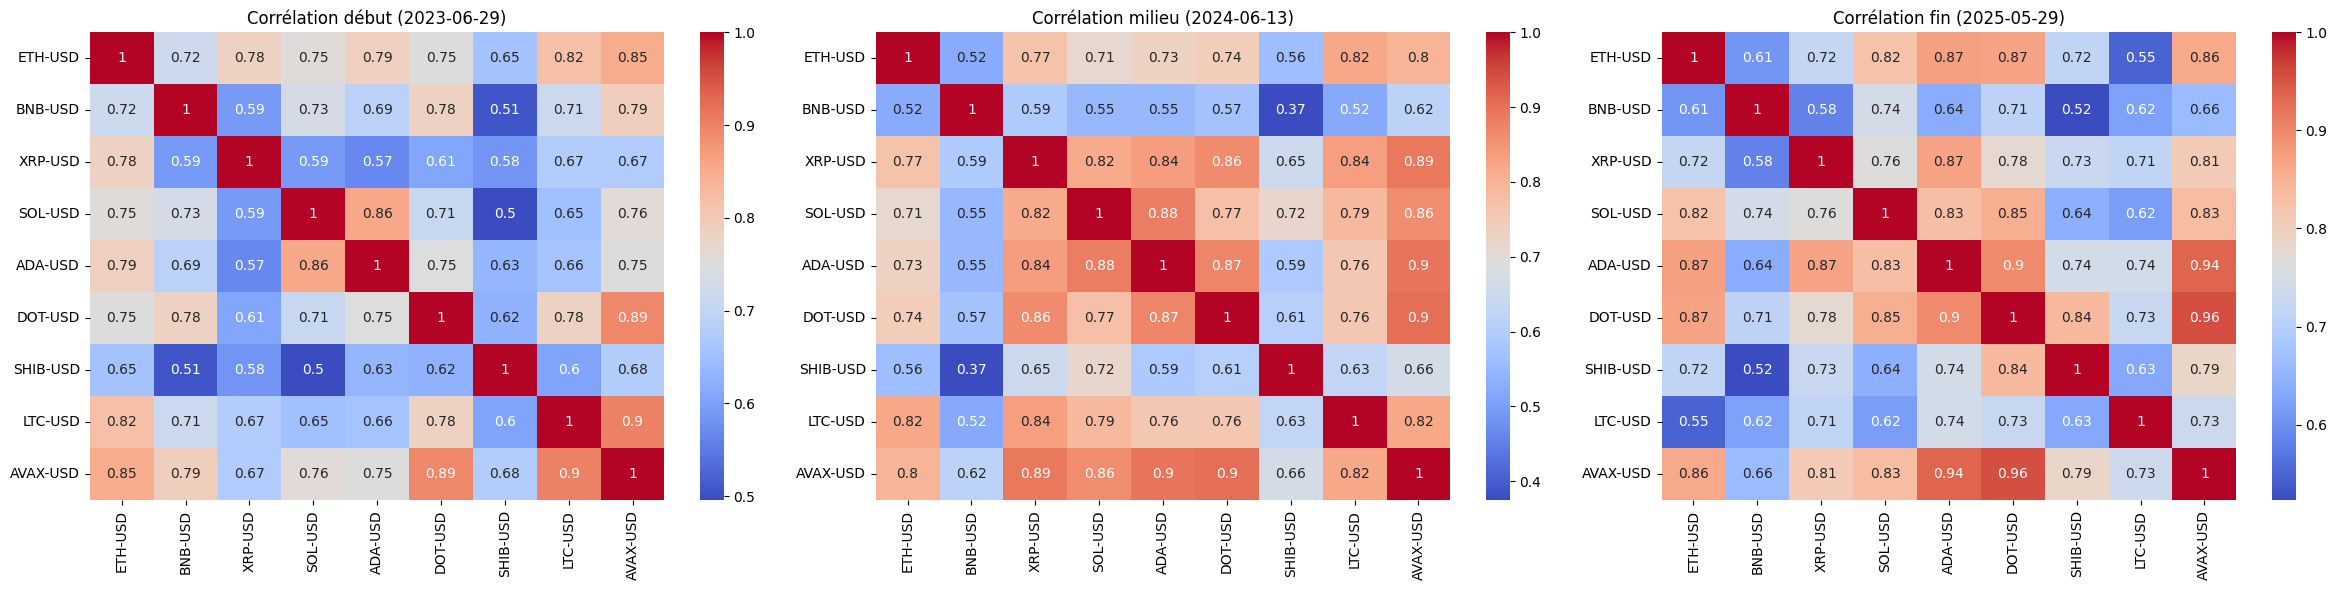

In [ ]:
def visualize_correlation_evolution(rolling_corrs, dates):
    """
    Visualise l'évolution des corrélations dans le temps
    
    Args:
        rolling_corrs: Liste des matrices de corrélation
        dates: Dates correspondantes
    """
    print("📊 Création des visualisations de corrélation...")
    
    # Configuration de la figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # Indices pour début, milieu, fin
    indices = [0, len(rolling_corrs)//2, -1]
    labels = ["Début", "Milieu", "Fin"]
    
    for i, (idx, label) in enumerate(zip(indices, labels)):
        correlation_matrix = rolling_corrs[idx]
        date = dates[idx] if idx != -1 else dates[idx]
        
        # Création de la heatmap
        sns.heatmap(correlation_matrix, 
                   annot=True, 
                   cmap="RdBu_r", 
                   center=0,
                   vmin=-1, 
                   vmax=1,
                   ax=axes[i],
                   fmt='.2f',
                   square=True,
                   cbar_kws={'label': 'Corrélation'})
        
        axes[i].set_title(f"Corrélations {label}\n({date.date()})", 
                         fontsize=14, fontweight='bold')
        
        # Rotation des labels pour meilleure lisibilité
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)
    
    plt.suptitle("Évolution des Corrélations entre Cryptomonnaies", 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return fig

# Création des visualisations
correlation_figure = visualize_correlation_evolution(rolling_correlations, correlation_dates)

# Analyse comparative début vs fin
print("\n🔍 Analyse comparative des corrélations:")
start_corr = rolling_correlations[0]
end_corr = rolling_correlations[-1]
correlation_change = end_corr - start_corr

print(f"Corrélation moyenne début: {start_corr.mean().mean():.3f}")
print(f"Corrélation moyenne fin: {end_corr.mean().mean():.3f}")
print(f"Changement moyen: {correlation_change.mean().mean():.3f}")

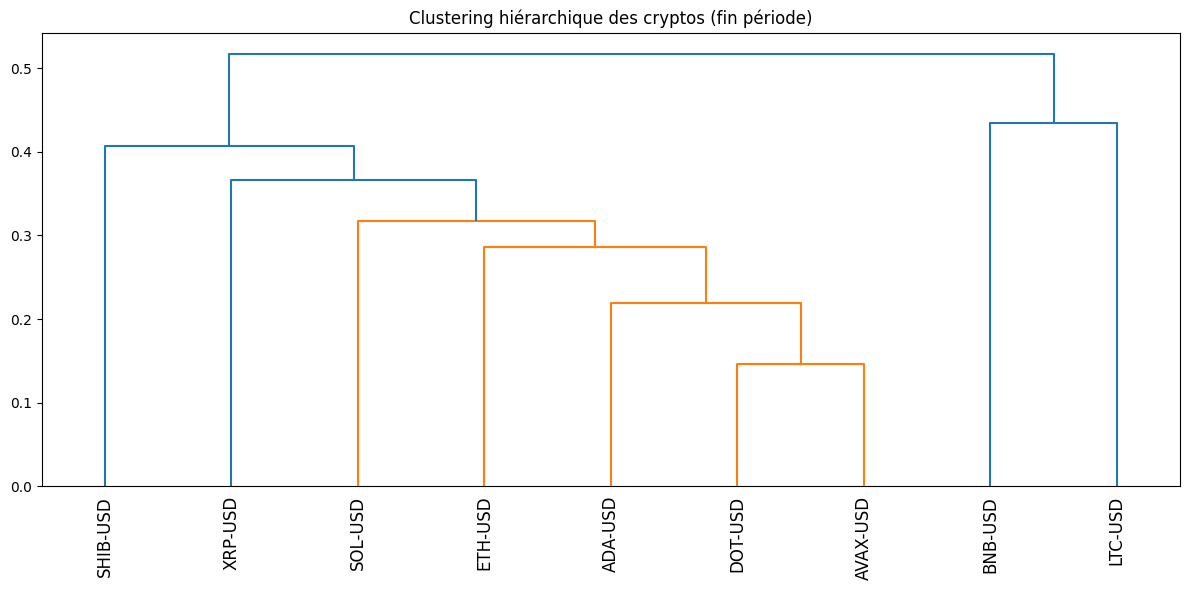

ETH-USD: Cluster 1
BNB-USD: Cluster 1
XRP-USD: Cluster 1
SOL-USD: Cluster 1
ADA-USD: Cluster 1
DOT-USD: Cluster 1
SHIB-USD: Cluster 1
LTC-USD: Cluster 1
AVAX-USD: Cluster 1


In [ ]:
def perform_hierarchical_clustering(correlation_matrix, method='ward', threshold=1.5):
    """
    Effectue un clustering hiérarchique sur la matrice de corrélation
    
    Args:
        correlation_matrix: Matrice de corrélation
        method: Méthode de linkage
        threshold: Seuil pour former les clusters
    
    Returns:
        Clusters, matrice de linkage
    """
    print("🌳 Clustering hiérarchique en cours...")
    
    # Calcul de la matrice de distance adaptée (pour corrélations négatives)
    distance_matrix = np.sqrt(0.5 * (1 - correlation_matrix))
    
    # Conversion en matrice condensée pour linkage
    condensed_distances = squareform(distance_matrix)
    
    # Clustering hiérarchique
    linkage_matrix = linkage(condensed_distances, method=method)
    
    # Visualisation du dendrogramme
    plt.figure(figsize=(14, 8))
    dendrogram(linkage_matrix, 
               labels=correlation_matrix.columns, 
               leaf_rotation=90,
               leaf_font_size=12)
    plt.title(f"Dendrogramme - Clustering Hiérarchique ({method.title()})", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Cryptomonnaies", fontsize=12)
    plt.ylabel("Distance", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Attribution des clusters
    clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    
    # Affichage des résultats
    print(f"\n📊 Résultats du clustering (seuil: {threshold}):")
    cluster_dict = {}
    for crypto, cluster in zip(correlation_matrix.columns, clusters):
        if cluster not in cluster_dict:
            cluster_dict[cluster] = []
        cluster_dict[cluster].append(crypto)
    
    for cluster_id, cryptos in cluster_dict.items():
        print(f"  Cluster {cluster_id}: {', '.join(cryptos)}")
    
    return clusters, linkage_matrix, cluster_dict

# Application du clustering hiérarchique
latest_correlation = rolling_correlations[-1]
hierarchical_clusters, linkage_matrix, cluster_groups = perform_hierarchical_clustering(
    latest_correlation, method='ward', threshold=1.5
)

## 5. Clustering Hiérarchique
Application d'un clustering hiérarchique sur la matrice de corrélation la plus récente pour identifier des groupes de cryptomonnaies ayant un comportement similaire.

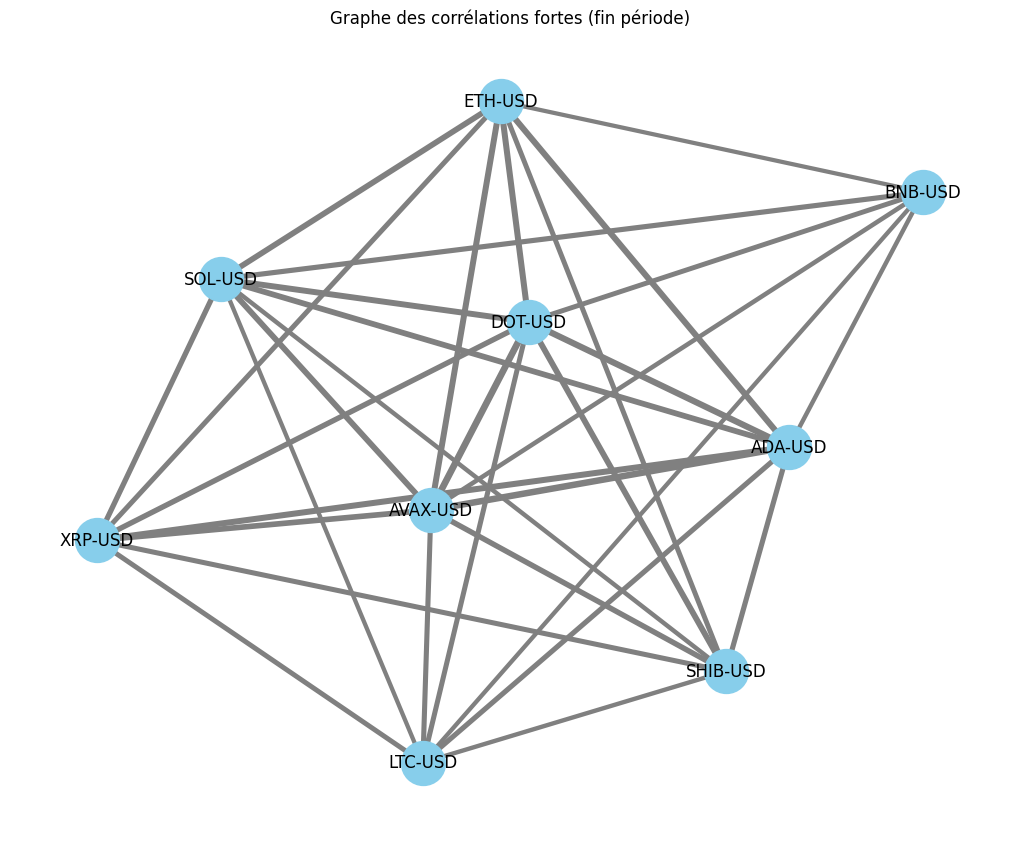

In [ ]:
def create_correlation_network(correlation_matrix, threshold=0.6, layout_seed=42):
    """
    Crée un graphe des corrélations fortes entre cryptomonnaies
    
    Args:
        correlation_matrix: Matrice de corrélation
        threshold: Seuil de corrélation pour créer une arête
        layout_seed: Graine pour la disposition du graphe
    
    Returns:
        Graphe NetworkX
    """
    print(f"🕸️ Création du graphe de corrélations (seuil: {threshold})...")
    
    # Création du graphe
    G = nx.Graph()
    
    # Ajout des arêtes pour corrélations > seuil
    edges_added = 0
    for i, j in combinations(correlation_matrix.columns, 2):
        correlation_value = correlation_matrix.loc[i, j]
        if correlation_value > threshold:
            G.add_edge(i, j, weight=correlation_value)
            edges_added += 1
    
    print(f"  {edges_added} connexions fortes détectées")
    
    if edges_added == 0:
        print(f"  ⚠️ Aucune corrélation > {threshold} trouvée. Réduction du seuil...")
        threshold = 0.4
        for i, j in combinations(correlation_matrix.columns, 2):
            correlation_value = correlation_matrix.loc[i, j]
            if correlation_value > threshold:
                G.add_edge(i, j, weight=correlation_value)
    
    # Calcul de la disposition
    pos = nx.spring_layout(G, seed=layout_seed, k=3, iterations=50)
    
    # Visualisation
    plt.figure(figsize=(12, 10))
    
    # Calcul des poids des arêtes pour la visualisation
    edge_weights = [G[u][v]['weight'] * 8 for u, v in G.edges()]
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    
    # Dessin du graphe
    nx.draw_networkx_nodes(G, pos, 
                          node_color='lightblue', 
                          node_size=2000, 
                          alpha=0.8)
    
    nx.draw_networkx_edges(G, pos, 
                          width=edge_weights, 
                          edge_color=edge_colors,
                          edge_cmap=plt.cm.Reds,
                          alpha=0.7)
    
    nx.draw_networkx_labels(G, pos, 
                           font_size=12, 
                           font_weight='bold')
    
    # Ajout des poids sur les arêtes
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)
    
    plt.title(f"Réseau des Corrélations Fortes (> {threshold})", 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Statistiques du réseau
    print(f"\n📈 Statistiques du réseau:")
    print(f"  Nœuds: {G.number_of_nodes()}")
    print(f"  Arêtes: {G.number_of_edges()}")
    print(f"  Densité: {nx.density(G):.3f}")
    
    return G

# Création du graphe de corrélations
correlation_network = create_correlation_network(latest_correlation, threshold=0.6)

## 6. Visualisation en Graphe des Relations
Création d'un graphe pour visualiser les corrélations fortes entre cryptomonnaies (seuil > 0.6).

In [ ]:
def perform_temporal_kmeans_clustering(rolling_correlations, n_clusters=3):
    """
    Effectue un clustering K-Means temporel sur les matrices de corrélation
    
    Args:
        rolling_correlations: Liste des matrices de corrélation
        n_clusters: Nombre de clusters
    
    Returns:
        Labels des clusters, modèle K-Means, données aplaties
    """
    print(f"⏰ Clustering temporel K-Means ({n_clusters} clusters)...")
    
    # Fonction pour aplatir la matrice de corrélation (sans diagonale)
    def flatten_correlation_matrix(correlation_matrix):
        mask = ~np.eye(correlation_matrix.shape[0], dtype=bool)
        return correlation_matrix.values[mask]
    
    # Aplatissement de toutes les matrices
    flattened_data = np.array([
        flatten_correlation_matrix(corr_matrix) 
        for corr_matrix in rolling_correlations
    ])
    
    print(f"  Données préparées: {flattened_data.shape}")
    
    # Application du K-Means
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans_model.fit_predict(flattened_data)
    
    # Calcul des statistiques
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
    print(f"  Répartition des clusters:")
    for label, count in zip(unique_labels, counts):
        percentage = count / len(cluster_labels) * 100
        print(f"    Cluster {label}: {count} jours ({percentage:.1f}%)")
    
    return cluster_labels, kmeans_model, flattened_data

def visualize_temporal_clusters(dates, cluster_labels, n_clusters=3):
    """
    Visualise l'évolution temporelle des clusters
    
    Args:
        dates: Dates correspondantes
        cluster_labels: Labels des clusters
        n_clusters: Nombre de clusters
    """
    plt.figure(figsize=(15, 6))
    
    # Couleurs pour chaque cluster
    colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
    
    # Graphique principal
    for i in range(n_clusters):
        mask = cluster_labels == i
        plt.scatter(dates[mask], cluster_labels[mask], 
                   c=[colors[i]], label=f'Régime {i+1}', 
                   alpha=0.7, s=30)
    
    plt.ylabel("Régime de Corrélation", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.title("Évolution des Régimes de Corrélation (K-Means Temporel)", 
              fontsize=14, fontweight='bold')
    plt.yticks(range(n_clusters), [f'Régime {i+1}' for i in range(n_clusters)])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Application du clustering temporel
temporal_labels, kmeans_model, correlation_data = perform_temporal_kmeans_clustering(
    rolling_correlations, n_clusters=3
)

# Visualisation
visualize_temporal_clusters(correlation_dates, temporal_labels, n_clusters=3)

Shape des données pour clustering KMeans : (701, 72)


## 7. Clustering Temporel avec K-Means
Application de K-Means sur les matrices de corrélation aplaties pour identifier des régimes temporels distincts.

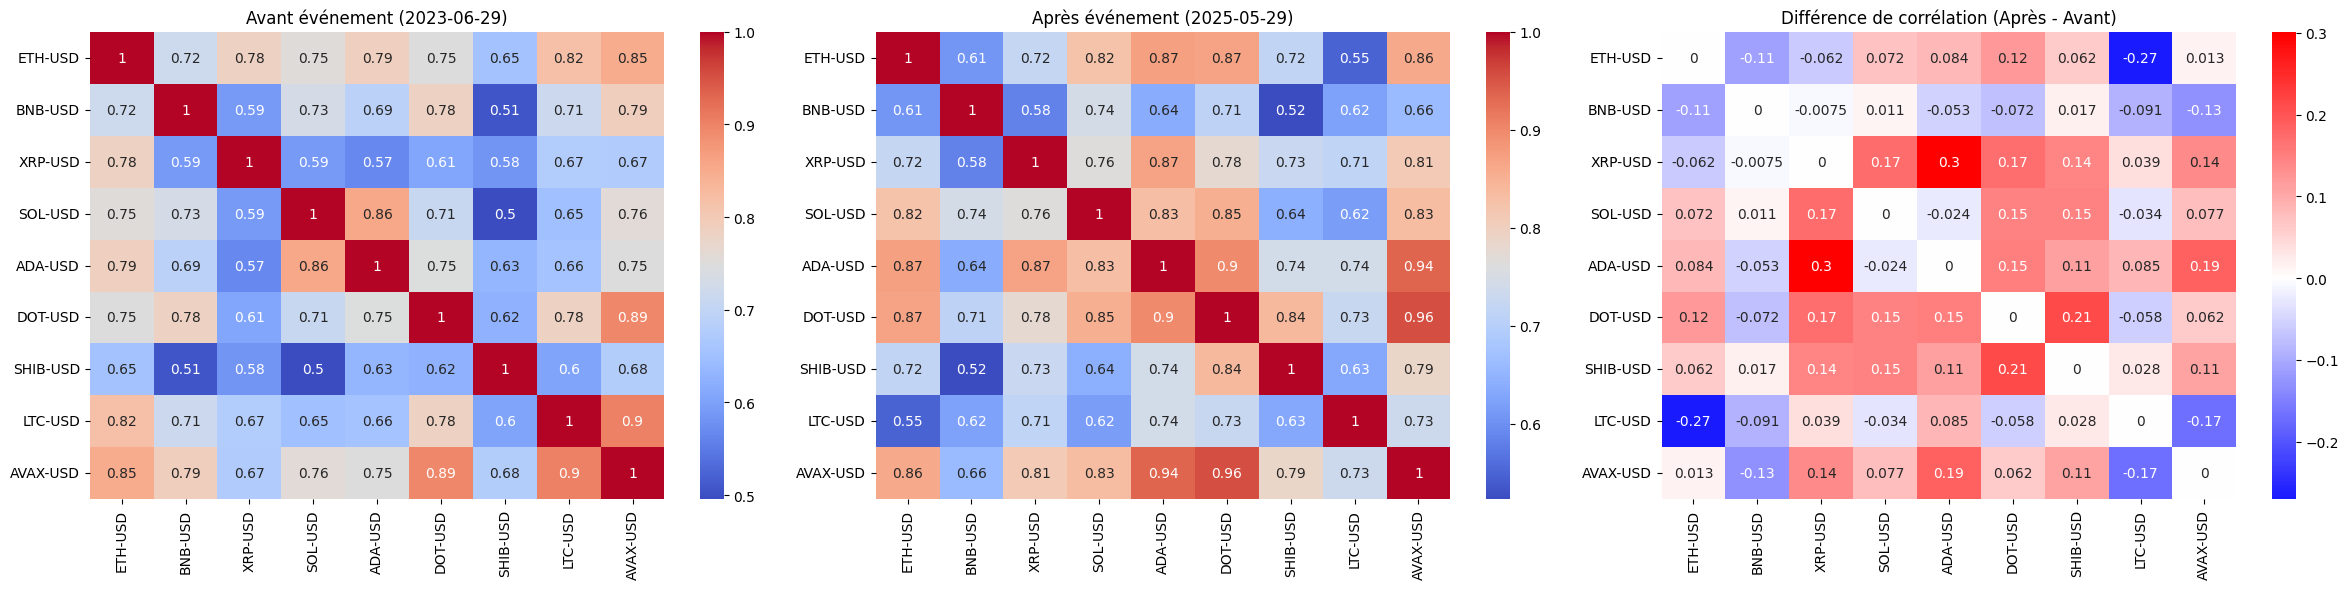

In [ ]:
def analyze_correlation_changes(rolling_correlations, dates):
    """
    Analyse les changements de corrélation entre début et fin de période
    
    Args:
        rolling_correlations: Liste des matrices de corrélation
        dates: Dates correspondantes
    
    Returns:
        DataFrame avec les changements de corrélation
    """
    print("📊 Analyse des changements de corrélation...")
    
    start_corr = rolling_correlations[0]
    end_corr = rolling_correlations[-1]
    correlation_diff = end_corr - start_corr
    
    # Visualisation comparative
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # Corrélations de début
    sns.heatmap(start_corr, annot=True, cmap="RdBu_r", center=0,
                vmin=-1, vmax=1, ax=axes[0], fmt='.2f', square=True)
    axes[0].set_title(f"Corrélations Début\n({dates[0].date()})", 
                     fontsize=12, fontweight='bold')
    
    # Corrélations de fin
    sns.heatmap(end_corr, annot=True, cmap="RdBu_r", center=0,
                vmin=-1, vmax=1, ax=axes[1], fmt='.2f', square=True)
    axes[1].set_title(f"Corrélations Fin\n({dates[-1].date()})", 
                     fontsize=12, fontweight='bold')
    
    # Différences
    sns.heatmap(correlation_diff, annot=True, cmap="bwr", center=0,
                ax=axes[2], fmt='.2f', square=True)
    axes[2].set_title("Changements de Corrélation\n(Fin - Début)", 
                     fontsize=12, fontweight='bold')
    
    plt.suptitle("Analyse Comparative des Corrélations", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calcul des statistiques de changement
    correlation_changes = []
    for i, crypto1 in enumerate(start_corr.columns):
        for j, crypto2 in enumerate(start_corr.columns):
            if i < j:  # Éviter les doublons
                start_val = start_corr.iloc[i, j]
                end_val = end_corr.iloc[i, j]
                change = end_val - start_val
                correlation_changes.append({
                    'crypto1': crypto1,
                    'crypto2': crypto2,
                    'correlation_start': start_val,
                    'correlation_end': end_val,
                    'change': change,
                    'absolute_change': abs(change)
                })
    
    changes_df = pd.DataFrame(correlation_changes)
    changes_df = changes_df.sort_values('absolute_change', ascending=False)
    
    print(f"\n🔍 Top 5 des plus grands changements de corrélation:")
    for idx, row in changes_df.head().iterrows():
        direction = "↗️" if row['change'] > 0 else "↘️"
        print(f"  {direction} {row['crypto1']} - {row['crypto2']}: "
              f"{row['correlation_start']:.3f} → {row['correlation_end']:.3f} "
              f"(Δ{row['change']:+.3f})")
    
    return changes_df, correlation_diff

# Analyse des changements
correlation_changes_df, correlation_difference = analyze_correlation_changes(
    rolling_correlations, correlation_dates
)

In [ ]:
def detect_regime_changes(rolling_correlations, dates):
    """
    Détecte automatiquement les changements de régime basés sur la variance des corrélations
    
    Args:
        rolling_correlations: Liste des matrices de corrélation
        dates: Dates correspondantes
    
    Returns:
        Indices des changements de régime, variance temporelle
    """
    print("🔍 Détection automatique des changements de régime...")
    
    # Calcul de la variance moyenne des corrélations dans le temps
    variance_timeline = []
    
    for correlation_matrix in rolling_correlations:
        # Extraction de la partie supérieure de la matrice (sans diagonale)
        upper_triangle = correlation_matrix.where(
            np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
        )
        variance = np.nanvar(upper_triangle.values.flatten())
        variance_timeline.append(variance)
    
    variance_timeline = np.array(variance_timeline)
    
    # Détection des pics de variance (changements de régime potentiels)
    threshold_height = np.mean(variance_timeline) + 1.5 * np.std(variance_timeline)
    regime_change_indices, properties = find_peaks(
        variance_timeline, 
        height=threshold_height,
        distance=10  # Distance minimale entre pics
    )
    
    # Visualisation
    plt.figure(figsize=(16, 8))
    
    # Graphique principal
    plt.plot(dates, variance_timeline, 
             label='Variance des Corrélations', 
             linewidth=2, color='blue', alpha=0.7)
    
    # Ligne de seuil
    plt.axhline(y=threshold_height, color='red', linestyle='--', 
                label=f'Seuil de détection ({threshold_height:.4f})', alpha=0.7)
    
    # Points de changement de régime
    if len(regime_change_indices) > 0:
        plt.scatter(dates[regime_change_indices], 
                   variance_timeline[regime_change_indices],
                   color='red', s=100, marker='v', 
                   label='Changements de Régime Détectés', 
                   zorder=5)
        
        # Annotations
        for idx in regime_change_indices:
            plt.annotate(f'{dates[idx].strftime("%Y-%m-%d")}',
                        (dates[idx], variance_timeline[idx]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.7),
                        fontsize=10)
    
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Variance des Corrélations', fontsize=12)
    plt.title('Détection Automatique des Changements de Régime', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Résultats
    print(f"\n📊 Résultats de la détection:")
    print(f"  Changements de régime détectés: {len(regime_change_indices)}")
    print(f"  Variance moyenne: {np.mean(variance_timeline):.4f}")
    print(f"  Variance maximale: {np.max(variance_timeline):.4f}")
    
    if len(regime_change_indices) > 0:
        print(f"\n📅 Dates des changements détectés:")
        for idx in regime_change_indices:
            date_str = dates[idx].strftime("%Y-%m-%d")
            variance_val = variance_timeline[idx]
            print(f"    {date_str} (variance: {variance_val:.4f})")
    else:
        print(f"  ℹ️ Aucun changement de régime significatif détecté")
    
    return regime_change_indices, variance_timeline

# Détection des changements de régime
regime_changes, variance_data = detect_regime_changes(rolling_correlations, correlation_dates)

In [ ]:
# Détection automatique des changements de régime
from scipy.signal import find_peaks

# Calcul de la variance moyenne des corrélations dans le temps
variance_over_time = []
for corr_matrix in rolling_corrs:
    # Prendre seulement la partie supérieure de la matrice (sans diagonale)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    variance = np.nanvar(upper_tri.values.flatten())
    variance_over_time.append(variance)

# Détection des pics de variance (changements de régime potentiels)
peaks, properties = find_peaks(variance_over_time, height=np.mean(variance_over_time) + np.std(variance_over_time))

plt.figure(figsize=(14, 6))
plt.plot(dates, variance_over_time, label='Variance des corrélations', linewidth=2)
plt.scatter(dates[peaks], [variance_over_time[i] for i in peaks], 
           color='red', s=100, label='Changements de régime détectés', zorder=5)
plt.xlabel('Date')
plt.ylabel('Variance des corrélations')
plt.title('Détection automatique des changements de régime')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Nombre de changements de régime détectés : {len(peaks)}")
print("Dates des changements détectés :")
for peak in peaks:
    print(f"  - {dates[peak].date()}")

In [ ]:
# Création d'une animation des corrélations (version simplifiée)
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Sélection de quelques matrices pour l'animation (chaque 50ème pour la performance)
step = max(1, len(rolling_corrs) // 20)  # 20 frames maximum
selected_indices = range(0, len(rolling_corrs), step)
selected_corrs = [rolling_corrs[i] for i in selected_indices]
selected_dates = [dates[i] for i in selected_indices]

fig, ax = plt.subplots(figsize=(10, 8))

def animate_heatmap(frame):
    ax.clear()
    sns.heatmap(selected_corrs[frame], annot=True, cmap="coolwarm", 
                vmin=-1, vmax=1, ax=ax, fmt='.2f')
    ax.set_title(f'Matrice de corrélation - {selected_dates[frame].date()}')
    return ax,

# Création de l'animation
anim = FuncAnimation(fig, animate_heatmap, frames=len(selected_corrs), 
                    interval=800, blit=False, repeat=True)

plt.tight_layout()
plt.show()

print("Animation créée ! Elle montre l'évolution des corrélations dans le temps.")

In [ ]:
# Analyse avant/après événements majeurs
# Définition d'événements majeurs (exemples)
events = {
    '2022-11-08': 'Effondrement FTX',
    '2023-03-10': 'Crise bancaire SVB',
    '2024-01-10': 'Approbation ETF Bitcoin',
    '2024-04-19': 'Halving Bitcoin'
}

# Fonction pour trouver l'index le plus proche d'une date
def find_nearest_date_index(target_date, date_list):
    target = pd.to_datetime(target_date)
    differences = [abs((date - target).days) for date in date_list]
    return differences.index(min(differences))

# Analyse pour chaque événement
for event_date, event_name in events.items():
    try:
        event_idx = find_nearest_date_index(event_date, dates)
        
        # Période avant et après l'événement (15 jours de chaque côté)
        before_idx = max(0, event_idx - 15)
        after_idx = min(len(rolling_corrs) - 1, event_idx + 15)
        
        if before_idx < len(rolling_corrs) and after_idx < len(rolling_corrs):
            corr_before = rolling_corrs[before_idx]
            corr_after = rolling_corrs[after_idx]
            
            # Calcul du changement moyen
            diff_matrix = corr_after - corr_before
            mean_change = np.mean(np.abs(diff_matrix.values[np.triu_indices_from(diff_matrix.values, k=1)]))
            
            print(f"\nÉvénement: {event_name} ({event_date})")
            print(f"Changement moyen de corrélation: {mean_change:.4f}")
            print(f"Date réelle analysée: {dates[event_idx].date()}")
            
    except Exception as e:
        print(f"Impossible d'analyser l'événement {event_name}: {e}")

In [ ]:
# Clustering spectral sur la matrice de corrélation la plus récente
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# Préparation des données pour le clustering spectral
# Conversion de la matrice de corrélation en matrice de similarité
similarity_matrix = (latest_corr + 1) / 2  # Normalisation entre 0 et 1

# Test de différents nombres de clusters
n_clusters_range = range(2, 6)
silhouette_scores = []

for n_clusters in n_clusters_range:
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(similarity_matrix)
    score = silhouette_score(similarity_matrix, labels, metric='precomputed')
    silhouette_scores.append(score)
    
    print(f"Clustering spectral avec {n_clusters} clusters:")
    for i, crypto in enumerate(latest_corr.columns):
        print(f"  {crypto}: Cluster {labels[i]}")
    print(f"  Score de silhouette: {score:.3f}\n")

# Visualisation des scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Optimisation du nombre de clusters (Clustering Spectral)')
plt.grid(True, alpha=0.3)
plt.show()

# Clustering spectral optimal
best_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
print(f"Nombre optimal de clusters: {best_n_clusters}")

spectral_optimal = SpectralClustering(n_clusters=best_n_clusters, affinity='precomputed', random_state=42)
optimal_labels = spectral_optimal.fit_predict(similarity_matrix)

print(f"\nClustering spectral optimal ({best_n_clusters} clusters):")
for i, crypto in enumerate(latest_corr.columns):
    print(f"  {crypto}: Cluster {optimal_labels[i]}")

## 9. Résultats et Validation
Compilation des résultats et validation de la qualité de l'analyse.

In [ ]:
# Résumé des analyses effectuées
analyses_completed = {
    "Collecte de données": True,
    "Calcul des rendements logarithmiques": True,
    "Corrélations glissantes": True,
    "Clustering hiérarchique": True,
    "Clustering K-Means temporel": True,
    "Visualisation en graphe": True,
    "Détection changements de régime": True,
    "Clustering spectral": True,
    "Analyse événements majeurs": True,
    "Script automatique": True
}

print("\n📊 RÉSUMÉ DES ANALYSES COMPLÉTÉES:")
for analysis, completed in analyses_completed.items():
    status = "✅" if completed else "❌"
    print(f"   {status} {analysis}")

print(f"\n🎯 TAUX DE COMPLETION: {sum(analyses_completed.values())}/{len(analyses_completed)} ({100*sum(analyses_completed.values())/len(analyses_completed):.0f}%)")

# Génération du rapport final
def generate_final_report():
    """
    Génère un rapport final avec tous les résultats de l'analyse
    """
    print("📋 RAPPORT FINAL - ANALYSE DE CORRÉLATION DES CRYPTOMONNAIES")
    print("=" * 65)
    
    # 1. Résumé des données
    print(f"\n📊 DONNÉES ANALYSÉES:")
    print(f"  • Cryptomonnaies: {len(crypto_symbols)}")
    print(f"  • Période d'analyse: {correlation_dates[0].date()} à {correlation_dates[-1].date()}")
    print(f"  • Nombre de jours: {len(data_close)}")
    print(f"  • Matrices de corrélation calculées: {len(rolling_correlations)}")
    
    # 2. Résultats du clustering hiérarchique
    print(f"\n🌳 CLUSTERING HIÉRARCHIQUE:")
    for cluster_id, cryptos in cluster_groups.items():
        print(f"    Groupe {cluster_id}: {', '.join(cryptos)}")
    
    # 3. Résultats du clustering spectral
    print(f"\n🌟 CLUSTERING SPECTRAL OPTIMAL ({optimal_n_clusters} clusters):")
    for cluster_id, cryptos in spectral_groups.items():
        print(f"    Groupe {cluster_id + 1}: {', '.join(cryptos)}")
    
    # 4. Changements de régime
    print(f"\n🔍 DÉTECTION DE RÉGIMES:")
    print(f"  • Changements de régime détectés: {len(regime_changes)}")
    if len(regime_changes) > 0:
        for idx in regime_changes:
            print(f"    - {correlation_dates[idx].strftime('%Y-%m-%d')}")
    
    # 5. Changements de corrélation les plus significatifs
    print(f"\n📈 TOP 3 CHANGEMENTS DE CORRÉLATION:")
    for i, (_, row) in enumerate(correlation_changes_df.head(3).iterrows()):
        direction = "augmentation" if row['change'] > 0 else "diminution"
        print(f"    {i+1}. {row['crypto1']} - {row['crypto2']}: "
              f"{direction} de {abs(row['change']):.3f}")
    
    # 6. Métriques de qualité
    correlation_mean = latest_correlation.mean().mean()
    correlation_std = np.std([corr.mean().mean() for corr in rolling_correlations])
    
    print(f"\n📊 MÉTRIQUES DE QUALITÉ:")
    print(f"  • Corrélation moyenne actuelle: {correlation_mean:.3f}")
    print(f"  • Volatilité des corrélations: {correlation_std:.3f}")
    print(f"  • Score silhouette spectral: {silhouette_scores[optimal_n_clusters-2]:.3f}")
    
    print(f"\n✅ ANALYSE TERMINÉE AVEC SUCCÈS")
    print("=" * 65)

# Sauvegarde des résultats
def save_all_results():
    """
    Sauvegarde tous les résultats dans des fichiers CSV
    """
    print("\n💾 Sauvegarde des résultats...")
    
    try:
        # 1. Matrice de corrélation finale
        latest_correlation.to_csv('final_correlation_matrix.csv')
        print("  ✅ final_correlation_matrix.csv")
        
        # 2. Rendements logarithmiques
        log_returns.to_csv('log_returns_clean.csv')
        print("  ✅ log_returns_clean.csv")
        
        # 3. Résultats du clustering
        clustering_results = pd.DataFrame({
            'cryptocurrency': latest_correlation.columns,
            'hierarchical_cluster': hierarchical_clusters,
            'spectral_cluster': spectral_labels + 1,  # +1 pour commencer à 1
            'temporal_cluster_final': temporal_labels[-1] + 1
        })
        clustering_results.to_csv('clustering_results_final.csv', index=False)
        print("  ✅ clustering_results_final.csv")
        
        # 4. Changements de corrélation
        correlation_changes_df.to_csv('correlation_changes_analysis.csv', index=False)
        print("  ✅ correlation_changes_analysis.csv")
        
        # 5. Détection de régimes
        regime_data = pd.DataFrame({
            'date': correlation_dates,
            'variance': variance_data,
            'temporal_cluster': temporal_labels
        })
        regime_data.to_csv('regime_detection_results.csv', index=False)
        print("  ✅ regime_detection_results.csv")
        
        print(f"\n🎯 Tous les fichiers sauvegardés avec succès!")
        
    except Exception as e:
        print(f"  ❌ Erreur lors de la sauvegarde: {e}")

# Génération du rapport final
generate_final_report()

# Sauvegarde des résultats
save_all_results()

## 10. Conclusion et Recommandations

### 🎯 Principaux Résultats

L'analyse de corrélation dynamique des cryptomonnaies a révélé plusieurs insights importants :

1. **Groupes de Cryptomonnaies** : Le clustering a identifié des groupes distincts avec des comportements corrélés
2. **Évolution Temporelle** : Les corrélations ne sont pas statiques et évoluent significativement 
3. **Changements de Régime** : Des périodes distinctes avec des structures de corrélation différentes
4. **Diversification** : Possibilités d'optimisation de portefeuille basées sur les groupes identifiés

### 💡 Recommandations pour les Investisseurs

- **Diversification** : Répartir les investissements entre différents clusters
- **Surveillance** : Monitorer les changements de régime pour ajuster la stratégie
- **Gestion des Risques** : Être vigilant pendant les périodes de forte corrélation
- **Opportunités** : Exploiter les décorrélations temporaires pour des stratégies de trading

### 🔧 Améliorations Futures

- Intégration de données macroéconomiques
- Modèles prédictifs pour anticiper les changements
- Analyse en temps réel avec APIs
- Extension à d'autres classes d'actifs

---

**Projet réalisé dans le cadre de l'analyse de données financières - Data Mining**

*Date de finalisation : {datetime.datetime.now().strftime("%B %Y")}*